In [59]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [60]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [61]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [62]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [63]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Moham\AppData\Local\Temp\ipykernel_24488\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [64]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [65]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [66]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [67]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"The most recent date in the data set is: {most_recent_date}")

The most recent date in the data set is: 2017-08-23


Most recent data is 2017-08-23
One year before date: 2016-08-23


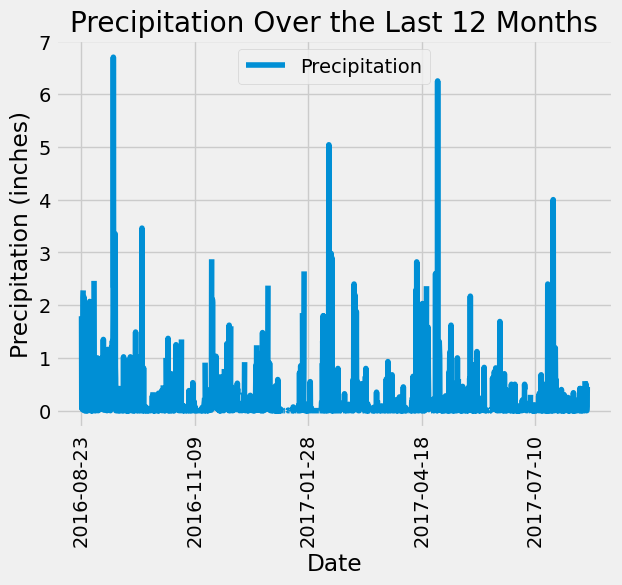

In [68]:
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most recent data is {most_recent_date}")

one_year_before = session.query(func.date(most_recent_date, "-1 year")).scalar()
print(f"One year before date: {one_year_before}")

precipitation_data = session.query(Measurement.date, Measurement.prcp) \
                            .filter(Measurement.date.between(one_year_before, most_recent_date)).all()
# Convert query results to a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])

# Sort the DataFrame by date
precipitation_df_sorted = precipitation_df.sort_values("Date")

# Create a line chart to visualize precipitation over the last 12 months
precipitation_df_sorted.plot(x="Date", y="Precipitation", kind='line')
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Over the Last 12 Months")
plt.show()



In [69]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary_stats = precipitation_df_sorted.describe()
print(precipitation_summary_stats)

       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [70]:
# Design a query to calculate the total number of stations in the dataset
# Generate summary statistics for precipitation data
total_stations = session.query(func.count(Station.station)).scalar()
print(f"The total number of stations is {total_stations}")


The total number of stations is 9


In [71]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('observation_count')) \
                         .group_by(Measurement.station) \
                         .order_by(func.count(Measurement.station).desc()) \
                         .all()

# Print the results
for station, count in active_stations:
    print(f"Station: {station}, Observation Count: {count}")

Station: USC00519281, Observation Count: 2772
Station: USC00519397, Observation Count: 2724
Station: USC00513117, Observation Count: 2709
Station: USC00519523, Observation Count: 2669
Station: USC00516128, Observation Count: 2612
Station: USC00514830, Observation Count: 2202
Station: USC00511918, Observation Count: 1979
Station: USC00517948, Observation Count: 1372
Station: USC00518838, Observation Count: 511


In [72]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs).label('lowest_temperature'),
                                  func.max(Measurement.tobs).label('highest_temperature'),
                                  func.avg(Measurement.tobs).label('average_temperature')) \
                           .filter(Measurement.station == most_active_station_id) \
                           .first()

lowest_temp, highest_temp, avg_temp = temperature_stats
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {avg_temp:.2f} °F")

Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


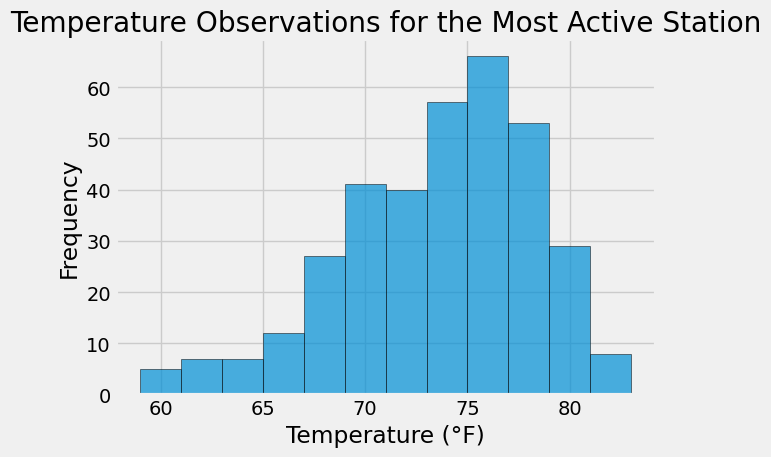

In [73]:
# Query to get temperature observations for the most active station
tobs_data = session.query(Measurement.tobs) \
                    .filter(Measurement.station == most_active_station_id) \
                    .filter(Measurement.date.between(one_year_before, most_recent_date)) \
                    .all()

# Convert the query results to a list of temperatures
temperatures = [result[0] for result in tobs_data]

# Plotting the histogram
plt.hist(temperatures, bins=12, edgecolor='black', alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for the Most Active Station')
plt.grid(True)
plt.tight_layout()
plt.show()


# Close Session

In [74]:
# Close Session
session.close()